# Simple Stock Prediction

Goal: Predict Alphabet Inc stock price using a Recurrent Neural Network (RNN)

Dataset from [Google Finance](https://www.google.com/finance)

Based on [RNN project: Time Series Prediction](https://github.com/udacity/aind2-rnn) project of the [Udacity's Artificial Intelligence  Nanodegree](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helper

## Load the data

In [2]:
df = pd.read_csv('data/alphabet_stock.csv')
print("Days: {}".format(len(df)))
df.head()

Days: 3253


,Date,Open,High,Low,Close,Volume
0,21-Jul-17,989.00,995.11,984.17,993.84,1463322
1,20-Jul-17,997.00,998.68,984.62,992.19,1418385
2,19-Jul-17,990.01,995.60,987.01,992.77,1412148
3,18-Jul-17,973.36,990.85,972.04,986.95,1413335
4,17-Jul-17,976.32,983.35,970.80,975.96,1660464


## Process the Data

In [3]:
# Parse dates 
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y', errors='coerce')
df.head()

,Date,Open,High,Low,Close,Volume
0,2017-07-21,989.00,995.11,984.17,993.84,1463322
1,2017-07-20,997.00,998.68,984.62,992.19,1418385
2,2017-07-19,990.01,995.60,987.01,992.77,1412148
3,2017-07-18,973.36,990.85,972.04,986.95,1413335
4,2017-07-17,976.32,983.35,970.80,975.96,1660464


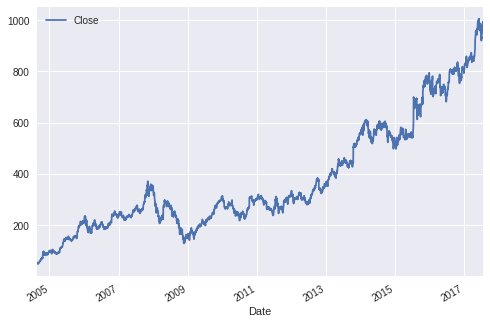

In [4]:
# Sort values by date
df = df.sort_values(by='Date')
df.plot(x='Date', y = 'Close')
plt.figure(figsize=(14, 4))

In [5]:
# Only Close prices will be used
data = df['Close'].values

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
data = scaler.fit_transform(data.reshape(-1,1))

data.reshape(-1)

array([-0.99966465, -0.9913018 , -0.99016998, ...,  0.97587558,
        0.97465993,  0.97811825])

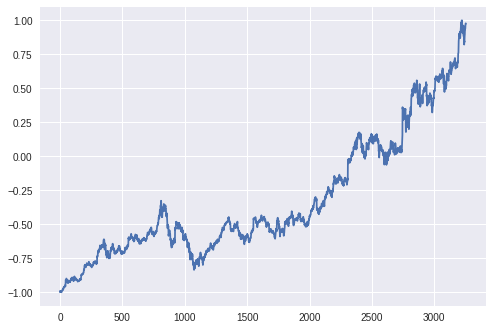

In [6]:
plt.plot(data)

## Split into sequences

Run a sliding window along the input series and creates associated input/output pairs

In [7]:
def window_transform_series(series,window_size):
    # containers for input/output pairs
    X = []
    y = []
    
    # fill input/output lists from the given sequence
    for i in range(len(series) - window_size):
        X.append(series[i : i + window_size])   # size: sliding window 
        y.append(series[i + window_size])       # size: scalar    
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    
    return X,y

In [8]:
# window the data 
window_size = 28   # Four weeks
X,y = window_transform_series(series = data,window_size = window_size)

## Split into training and testing sets

Here we are not splitting the dataset randomly as the input/output pairs are related temporally

In [9]:
# split our dataset into training / testing sets

train_test_split = int(len(X)*0.9)

X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# Keras's LSTM module requires input reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

## Recurrent Neural Network

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 264,449.0
Trainable params: 264,449
Non-trainable params: 0.0
_________________________________________________________________
Training ...
Epoch 00167: early stopping
Training loss: 0.0014
Validation loss: 0.00


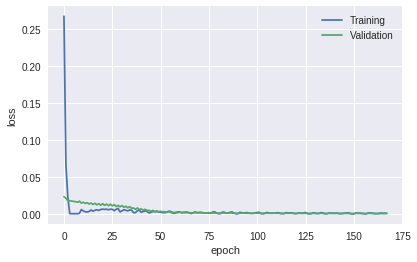

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

np.random.seed(9)

model = Sequential()  
model.add(LSTM(256, input_shape = (window_size,1)))  
model.add(Dense(1, activation=None)) # linear fully connected layer
model.summary()  

model.compile(loss='mean_squared_error', optimizer='rmsprop')

# train the model
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)]
print("Training ...")
history = model.fit(X_train, y_train, epochs=1000, batch_size=1024, verbose=0, 
                    validation_split=0.2, callbacks=callbacks)

helper.show_training(history)

## Evaluate the model

In [11]:
# print training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.000979065903344
testing error = 0.00202440602623


In [12]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

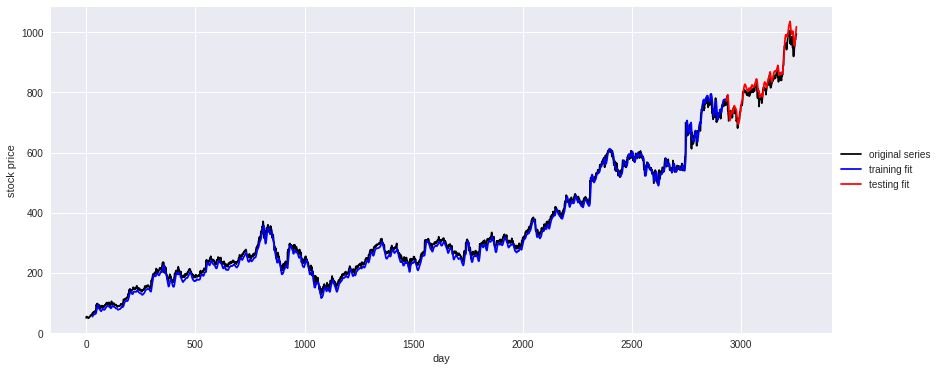

In [13]:
# revert scaling
data_or = scaler.inverse_transform(data)
train_predict_or = scaler.inverse_transform(train_predict)
test_predict_or = scaler.inverse_transform(test_predict)

plt.figure(figsize=(14, 6))

# plot original series
plt.plot(data_or,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1), train_predict_or, color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict_or),1), test_predict_or ,color = 'r')

plt.xlabel('day')
plt.ylabel('stock price')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))


Note that the stock prices are predicted daily using the actual data from the last 4 weeks; that explains why the predictions seem so accurate.